# sliceyslicey

this notebook's purpose is to find regions of interest in the ocean current maps and slice them out

in other words, find the regions with actual data and get some info about the coordinates

then pickle it to use the region data in `access_thredds` notebook

### note

to generate a pickle for a different region, change the `dataset_url` variable and rerun the whole notebook

In [1]:
%matplotlib inline

In [2]:
import copy
import math
import pickle
import sys
import time
import numpy as np
import xarray as xr
from parcels import FieldSet
from datetime import timedelta

In [3]:
dataset_url_6kmhourly = "http://hfrnet-tds.ucsd.edu/thredds/dodsC/HFR/USWC/6km/hourly/RTV/HFRADAR_US_West_Coast_6km_Resolution_Hourly_RTV_best.ncd"
dataset_url_2kmhourly = "http://hfrnet-tds.ucsd.edu/thredds/dodsC/HFR/USWC/2km/hourly/RTV/HFRADAR_US_West_Coast_2km_Resolution_Hourly_RTV_best.ncd"
dataset_url_1kmhourly = "http://hfrnet-tds.ucsd.edu/thredds/dodsC/HFR/USWC/1km/hourly/RTV/HFRADAR_US_West_Coast_1km_Resolution_Hourly_RTV_best.ncd"
filename_dict = {
    dataset_url_1kmhourly: "west_coast_1km_hourly",
    dataset_url_2kmhourly: "west_coast_2km_hourly",
    dataset_url_6kmhourly: "west_coast_6km_hourly"
}

### CHANGE THIS TO CHANGE THE DATA RETRIEVED ###
dataset_url = dataset_url_2kmhourly
### ######################################## ###

time_chunk_size = 50
chunk_dict = {"time": time_chunk_size}
to_drop = ["dopx", "dopy", "hdop", "number_of_sites", "number_of_radials"]

In [4]:
fs_xr = xr.open_dataset(dataset_url, chunks=chunk_dict, drop_variables=to_drop)
fs_xr

<xarray.Dataset>
Dimensions:                (lat: 1099, lon: 700, nv: 2, time: 73410, time_1: 1)
Coordinates:
  * lat                    (lat) float32 30.25 30.26798 ... 49.97406 49.99204
  * lon                    (lon) float32 -130.36 -130.33917 ... -115.805565
  * time                   (time) datetime64[ns] 2012-01-01 ... 2020-07-01T23:00:00
    time_run               (time) datetime64[ns] dask.array<chunksize=(50,), meta=np.ndarray>
Dimensions without coordinates: nv, time_1
Data variables:
    time_bnds              (time_1, nv) int32 dask.array<chunksize=(1, 2), meta=np.ndarray>
    depth_bnds             (nv) float32 dask.array<chunksize=(2,), meta=np.ndarray>
    wgs84                  int8 ...
    processing_parameters  int8 ...
    radial_metadata        int8 ...
    depth                  float32 ...
    time_offset            (time) datetime64[ns] dask.array<chunksize=(50,), meta=np.ndarray>
    u                      (time, lat, lon) float32 dask.array<chunksize=(50, 1099, 700), meta=np.ndarray>
    v                      (time, lat, lon) float32 dask.array<chunksize=(50, 1099, 700), meta=np.ndarray>
Attributes:
    Conventions:               CF-1.4, ACDD-1.3
    id:                        202007011900siohfruwlsrtvuswc2km
    date_created:              2020-07-01T21:20:25Z
    source:                    surface ocean velocity field from hf-radar
    program:                   Integrated Ocean Observing System (IOOS)
    title:                     Near-Real Time Surface Ocean Velocity, U.S. We...
    summary:                   Surface ocean velocities estimated from HF-Rad...
    instrument:                Earth Remote Sensing Instruments, Active Remot...
    keywords:                  Earth Science, Oceans, Sea Surface, Coastal Pr...
    geospatial_lat_min:        30.25
    geospatial_lat_max:        49.99204
    geospatial_lon_min:        -130.36
    geospatial_lon_max:        -115.805565
    processing_level:          Near real-time dataset with automated data acq...
    history:                   2020-07-01T20:20:41Z hfrnet rtvMergeData: Savi...
    references:                Terrill, E. et al., 2006. Data Management and ...
    institution:               Coastal Observing Research and Development Cen...
    creator_type:              group
    creator_name:              HFRNet Administrators
    creator_email:             hfrnet.administrators@sio.ucsd.edu
    creator_url:               http://cordc.ucsd.edu/projects/mapping/
    naming_authority:          edu.ucsd.cordc
    standard_name_vocabulary:  CF Standard Name Table, Version 51
    keywords_vocabulary:       Global Change Master Directory (GCMD) Keywords...
    instrument_vocabulary:     Global Change Master Directory (GCMD) Keywords...
    format_version:            1.1.00
    product_version:           2.0.00
    _CoordSysBuilder:          ucar.nc2.dataset.conv.CF1Convention
    cdm_data_type:             GRID
    featureType:               GRID
    location:                  Proto fmrc:HFRADAR_US_West_Coast_2km_Resolutio...

### sampling data at multiple times

for some hours of data, parts of the data aren't recorded or available to avoid forgetting about the lost data, we check multiple hours of data vs just using the latest data as reference

on the contrary, if some important radar went offline for a particularly long time, this won't work well

In [5]:
timespan_to_sample = np.timedelta64(15,'h')
time_end = fs_xr["time"].max()
time_start = time_end - timespan_to_sample
fs_xr_slice = fs_xr.sel(time=slice(time_start, time_end))
fs_xr_slice

<xarray.Dataset>
Dimensions:                (lat: 1099, lon: 700, nv: 2, time: 16, time_1: 1)
Coordinates:
  * lat                    (lat) float32 30.25 30.26798 ... 49.97406 49.99204
  * lon                    (lon) float32 -130.36 -130.33917 ... -115.805565
  * time                   (time) datetime64[ns] 2020-07-01T08:00:00 ... 2020-07-01T23:00:00
    time_run               (time) datetime64[ns] dask.array<chunksize=(6,), meta=np.ndarray>
Dimensions without coordinates: nv, time_1
Data variables:
    time_bnds              (time_1, nv) int32 dask.array<chunksize=(1, 2), meta=np.ndarray>
    depth_bnds             (nv) float32 dask.array<chunksize=(2,), meta=np.ndarray>
    wgs84                  int8 ...
    processing_parameters  int8 ...
    radial_metadata        int8 ...
    depth                  float32 ...
    time_offset            (time) datetime64[ns] dask.array<chunksize=(6,), meta=np.ndarray>
    u                      (time, lat, lon) float32 dask.array<chunksize=(6, 1099, 700), meta=np.ndarray>
    v                      (time, lat, lon) float32 dask.array<chunksize=(6, 1099, 700), meta=np.ndarray>
Attributes:
    Conventions:               CF-1.4, ACDD-1.3
    id:                        202007011900siohfruwlsrtvuswc2km
    date_created:              2020-07-01T21:20:25Z
    source:                    surface ocean velocity field from hf-radar
    program:                   Integrated Ocean Observing System (IOOS)
    title:                     Near-Real Time Surface Ocean Velocity, U.S. We...
    summary:                   Surface ocean velocities estimated from HF-Rad...
    instrument:                Earth Remote Sensing Instruments, Active Remot...
    keywords:                  Earth Science, Oceans, Sea Surface, Coastal Pr...
    geospatial_lat_min:        30.25
    geospatial_lat_max:        49.99204
    geospatial_lon_min:        -130.36
    geospatial_lon_max:        -115.805565
    processing_level:          Near real-time dataset with automated data acq...
    history:                   2020-07-01T20:20:41Z hfrnet rtvMergeData: Savi...
    references:                Terrill, E. et al., 2006. Data Management and ...
    institution:               Coastal Observing Research and Development Cen...
    creator_type:              group
    creator_name:              HFRNet Administrators
    creator_email:             hfrnet.administrators@sio.ucsd.edu
    creator_url:               http://cordc.ucsd.edu/projects/mapping/
    naming_authority:          edu.ucsd.cordc
    standard_name_vocabulary:  CF Standard Name Table, Version 51
    keywords_vocabulary:       Global Change Master Directory (GCMD) Keywords...
    instrument_vocabulary:     Global Change Master Directory (GCMD) Keywords...
    format_version:            1.1.00
    product_version:           2.0.00
    _CoordSysBuilder:          ucar.nc2.dataset.conv.CF1Convention
    cdm_data_type:             GRID
    featureType:               GRID
    location:                  Proto fmrc:HFRADAR_US_West_Coast_2km_Resolutio...

In [6]:
lat_diff = float(fs_xr_slice["lat"].diff(dim="lat").max().values)
lon_diff = float(fs_xr_slice["lon"].diff(dim="lon").max().values)
print(lat_diff, lon_diff)

0.01798248291015625 0.0208282470703125


In [7]:
# rounding the stuff is fine since xarray does nearest neighbor lookups
lat_range = (math.floor(fs_xr_slice["lat"].min()), math.ceil(fs_xr_slice["lat"].max()))
lon_range = (math.floor(fs_xr_slice["lon"].min()), math.ceil(fs_xr_slice["lon"].max()))
print(lat_range, lon_range)

(30, 50) (-131, -115)


## finding areas of interest

a quickly conceived method of continuously dividing the map smaller and smaller

the more i look at the code the more jank it becomes

the only reason this works is because generally there's only one region of data in a latitudal region

this shit takes ages to run so grab a drink (up to five minutes)

In [8]:
# for adjacent regions found to be of interest, merge them together into one
def merge_regions(regs, diff, num_divs):
    merged = []
    i = 0
    while i < len(regs):
        start = regs[i]
        count = 1
        # region is as small as possible, don't bother merging
        # reached end of list, last element won't merge
        if start[2] or i >= len(regs) - 1:
            end = start
        else:
            while regs[i + 1][0] - regs[i][1] <= diff + sys.float_info.epsilon:
                count += 1
                i += 1
                # reached end of list, break
                if i == len(regs) - 1:
                    break
            end = regs[i]
        # the number of regions being merged equals the number of divisions
        # this means it cannot be divided further
        if start[2] or count == num_divs:
            merged.append((start[0], end[1], True))
        else:
            merged.append((start[0], end[1], False))
        i += 1
    print(merged)
    print("------------------------")
    return merged

In [9]:
# number of regions to divide the map into
# higher values are better if the regions are closer together
lat_divs = 18
lon_divs = 7

In [10]:
start = time.time()
# dividing latitude regions of interest
# regions have a flag as the 3rd element marking whether they are the smallest possible or not
# at the end of the algorithm, the flags won't necessarily be all True
lat_regions = [(lat_range[0], lat_range[1], False)]
lat_found = False
while not lat_found:
    prev_regions = lat_regions.copy()
    # clear regions to find new regions of interest
    lat_regions = []
    for r in prev_regions:
        if r[2]:
            lat_regions.append(r)
            continue
        # lat_divs + 1 or else we only get lat_divs - 1 regions
        r_secs = np.linspace(r[0], r[1], lat_divs + 1)
        for i in range(0, lat_divs):
            xr_slice = fs_xr_slice.sel(lat=slice(r_secs[i], r_secs[i + 1]), lon=slice(lon_range[0], lon_range[1]))
            # check if region actually has data
            # the main bottleneck, this check takes so long to run
            if not np.isnan(xr_slice["u"]).all().values:
                # append latitude values according to the coordinate values of the data
                lat_regions.append((float(xr_slice["lat"].min().values), float(xr_slice["lat"].max().values), False))
    lat_regions = merge_regions(lat_regions, lat_diff, lat_divs)
    # this check should be fine since it takes coordinates straight from the data itself
    if lat_regions == prev_regions:
        lat_found = True
end = time.time()
print(f"time elapsed: {end - start}")
lat_regions

[(32.22779846191406, 38.880401611328125, False), (43.339439392089844, 45.55097961425781, False), (47.78049850463867, 49.99203872680664, False)]
------------------------
[(32.22779846191406, 35.554100036621094, False), (36.309261322021484, 38.880401611328125, False), (43.9687385559082, 44.79581832885742, False), (48.1580810546875, 48.39181900024414, False), (48.76940155029297, 49.36273956298828, False)]
------------------------
[(32.22779846191406, 35.554100036621094, True), (36.309261322021484, 37.01047897338867, False), (37.316139221191406, 38.59272003173828, False), (44.02267837524414, 44.79581832885742, False), (48.1580810546875, 48.39181900024414, False), (48.877281188964844, 49.326778411865234, False)]
------------------------
[(32.22779846191406, 35.554100036621094, True), (36.36320114135742, 37.01047897338867, False), (37.316139221191406, 38.59272003173828, True), (44.02267837524414, 44.79581832885742, True), (48.1580810546875, 48.39181900024414, False), (48.877281188964844, 49.

[(32.22779846191406, 35.554100036621094, True),
 (36.36320114135742, 37.01047897338867, True),
 (37.316139221191406, 38.59272003173828, True),
 (44.02267837524414, 44.79581832885742, True),
 (48.1580810546875, 48.39181900024414, False),
 (48.877281188964844, 49.326778411865234, True)]

HFR 6km 52.875375270843506 seconds

HFR 2km 163.83207821846008 seconds w/o lat lon chunking

In [11]:
start = time.time()
# dividing each latitude region into longitude regions
# stored as a list of lists
lon_regions = [[(lon_range[0], lon_range[1], False)]] * len(lat_regions)
lon_found = False
while not lon_found:
    # deep copy list because it has lists inside
    prev_regions = copy.deepcopy(lon_regions)
    for s in range(0, len(lat_regions)):
        lon_regions[s] = []
        for r in prev_regions[s]:
            if r[2]:
                lon_regions[s].append(r)
                continue
            r_secs = np.linspace(r[0], r[1], lon_divs + 1)
            for i in range(0, lon_divs):
                xr_slice = fs_xr_slice.sel(lat=slice(lat_regions[s][0], lat_regions[s][1]), lon=slice(r_secs[i], r_secs[i + 1]))
                if not np.isnan(xr_slice["u"]).all().values:
                    lon_regions[s].append((float(xr_slice["lon"].min().values), float(xr_slice["lon"].max().values), False))
    for i in range(0, len(lon_regions)):
        lon_regions[i] = merge_regions(lon_regions[i], lon_diff, lon_divs)
    if lon_regions == prev_regions:
        lon_found = True
end = time.time()
print(f"time elapsed: {end - start}")
lon_regions

[(-121.84388732910156, -115.8055648803711, False)]
------------------------
[(-124.13428497314453, -119.57431030273438, False)]
------------------------
[(-124.13428497314453, -121.86470794677734, False)]
------------------------
[(-126.4246826171875, -121.86470794677734, False)]
------------------------
[(-126.4246826171875, -121.86470794677734, False)]
------------------------
[(-124.13428497314453, -121.86470794677734, False)]
------------------------
[(-121.84388732910156, -116.6800765991211, False)]
------------------------
[(-122.822509765625, -121.53155517578125, False)]
------------------------
[(-123.80113220214844, -122.1978530883789, False)]
------------------------
[(-125.11290740966797, -123.82195281982422, False)]
------------------------
[(-124.4674301147461, -123.17647552490234, False)]
------------------------
[(-123.80113220214844, -122.84333038330078, False)]
------------------------
[(-121.84388732910156, -116.6800765991211, True)]
------------------------
[(-122.82

[[(-121.84388732910156, -116.6800765991211, True)],
 [(-122.822509765625, -121.71895599365234, True)],
 [(-123.80113220214844, -122.1978530883789, True)],
 [(-124.63400268554688, -124.00935363769531, True)],
 [(-124.28003692626953, -123.36387634277344, True)],
 [(-123.65538024902344, -122.98908233642578, True)]]

### the pickle dump

where the data does dumps

In [14]:
regs = []
for i in range(0, len(lat_regions)):
    for lonr in lon_regions[i]:
        regs.append((lat_regions[i], lonr))
d = filename_dict[dataset_url]
with open(f"regions_{d}.p", "wb") as f:
    pickle.dump(regs, f)

### plots of regions found

mostly for debugging purposes

(32, 36)
sum U: -1778.349609375


/Users/jerry/opt/anaconda3/envs/py3_parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/jerry/opt/anaconda3/envs/py3_parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


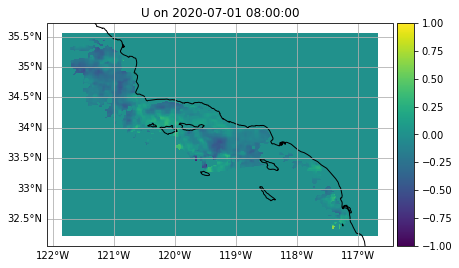

(36, 38)
sum U: -167.02996826171875


/Users/jerry/opt/anaconda3/envs/py3_parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/jerry/opt/anaconda3/envs/py3_parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


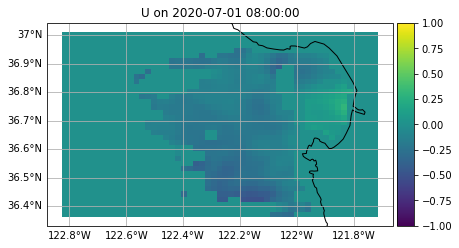

(37, 39)
sum U: -1548.030029296875


/Users/jerry/opt/anaconda3/envs/py3_parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/jerry/opt/anaconda3/envs/py3_parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


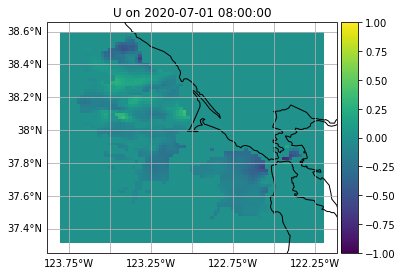

(44, 45)
sum U: -1608.1700439453125


/Users/jerry/opt/anaconda3/envs/py3_parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/jerry/opt/anaconda3/envs/py3_parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


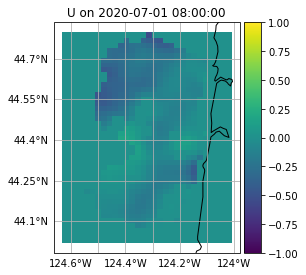

(48, 49)
sum U: -926.489990234375


/Users/jerry/opt/anaconda3/envs/py3_parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/jerry/opt/anaconda3/envs/py3_parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


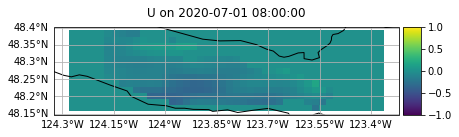

(48, 50)
sum U: 45.989994049072266


/Users/jerry/opt/anaconda3/envs/py3_parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/jerry/opt/anaconda3/envs/py3_parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


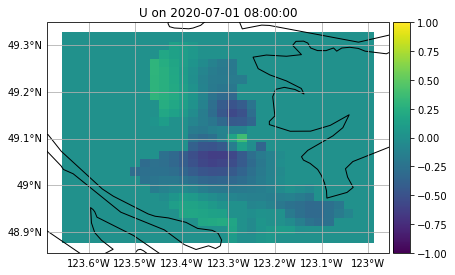

In [15]:
# show a plot of all the regions of interest found
for i in range(0, len(lat_regions)):
    for lonr in lon_regions[i]:
        xarr_sliced = fs_xr_slice.sel(lat=slice(lat_regions[i][0], lat_regions[i][1]), lon=slice(lonr[0], lonr[1]))
        print((math.floor(xarr_sliced["lat"].min()), math.ceil(xarr_sliced["lat"].max())))
    #     print(xarr_sliced["u"].sum())
        a = xarr_sliced["u"].sum().values
        print(f"sum U: {a}")
        fs_sliced = FieldSet.from_xarray_dataset(xarr_sliced, dict(U="u",V="v"), dict(lat="lat",lon="lon",time="time"))
        fs_sliced.U.show(vmin=-1, vmax=1)